### 1. Load data  

In [3]:
import os
import pandas as pd

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

### 2. Check the dataset

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 3. Inspect missingness in the dataset

<AxesSubplot:>

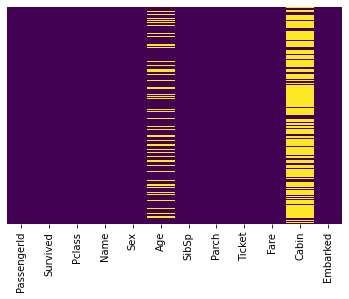

In [5]:
import seaborn as sns
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### 4. Drop Cabin column since it has so many missigness

In [6]:
train.drop('Cabin',axis=1,inplace=True)

In [7]:
test.drop('Cabin',axis=1,inplace=True)

### 5. Plot columns that may contribute to survival

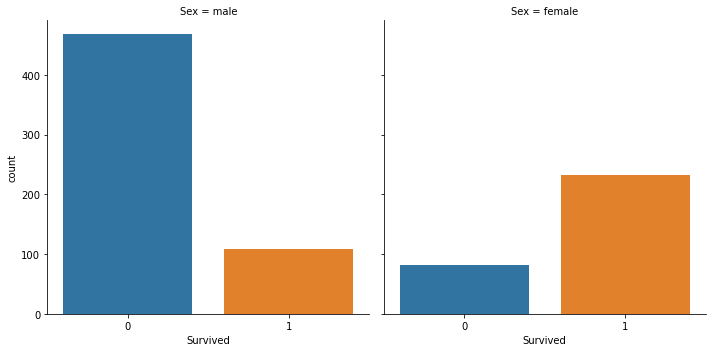

In [8]:
import warnings
warnings.filterwarnings('ignore')
sns.factorplot(x='Survived',col='Sex',kind='count',data=train)

<AxesSubplot:xlabel='Survived', ylabel='count'>

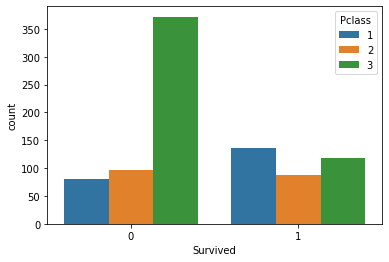

In [9]:
sns.countplot(x='Survived',hue='Pclass',data=train)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

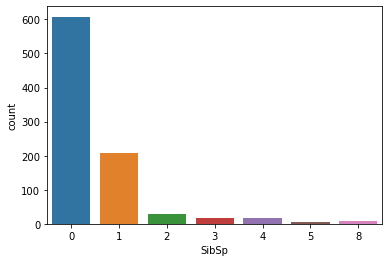

In [10]:
sns.countplot(x='SibSp',data=train)

### 6. Determine whether the age can be imputed by the mean or not

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

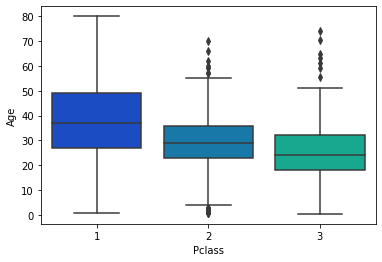

In [11]:
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

In [12]:
def impute(cols):
    Age = cols[0]
    Pclass=cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 38
        elif Pclass == 2:
            return 29
        else:
            return 24
        
    else:
        return Age

In [13]:
train['Age']=train[['Age','Pclass']].apply(impute,axis=1)

In [14]:
test['Age']=test[['Age','Pclass']].apply(impute,axis=1)

<AxesSubplot:>

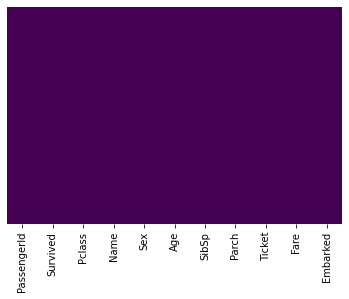

In [15]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### 7. Convert categorical value into number and add it to the train set

In [16]:
embark=pd.get_dummies(train['Embarked'],drop_first=True) 
sex=pd.get_dummies(train['Sex'],drop_first=True)

In [17]:
train.drop(['Sex','Embarked','Name','Ticket','PassengerId'],axis=1,inplace=True)
train=pd.concat([train,sex,embark],axis=1)

In [18]:
embark=pd.get_dummies(test['Embarked'],drop_first=True) 
sex=pd.get_dummies(test['Sex'],drop_first=True)
test.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
test=pd.concat([test,sex,embark],axis=1)

In [19]:
train.sample(5)

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
726,1,2,30.0,3,0,21.0000,0,0,1
403,0,3,28.0,1,0,15.8500,1,0,1
187,1,1,45.0,0,0,26.5500,1,0,1
96,0,1,71.0,0,0,34.6542,1,0,0
854,0,2,44.0,1,0,26.0000,0,0,1


In [20]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,892,3,34.5,0,0,7.8292,1,1,0
1,893,3,47.0,1,0,7.0000,0,0,1
2,894,2,62.0,0,0,9.6875,1,1,0
3,895,3,27.0,0,0,8.6625,1,0,1
4,896,3,22.0,1,1,12.2875,0,0,1


### 8. Split the train set

In [21]:
from sklearn.model_selection import train_test_split
target = "Survived"

X = train.drop(target,1)
y = train[target]
seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

### 9. Train Random Forest Classifier

In [22]:
seed = 42

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(
    n_estimators=100,
    random_state=seed, 
    criterion='entropy',
    max_depth=None, 
    min_samples_split=2)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

# evaluate predictions
accuracy = model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.56%


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[90 15]
 [18 56]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       105
           1       0.79      0.76      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.81      0.82      0.82       179



<AxesSubplot:>

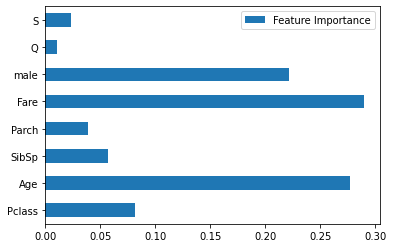

In [24]:
feat_importance = model.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
            index=list(X)).plot(kind='barh')

In [25]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model,X,y, cv=5, n_jobs=-1)
print("Accuracy: %0.2f%% (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Accuracy: 81.26% (+/- 6.46)


In [26]:
param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 50, 55, 60, 65, 70, 75, 80,85, 90, 95, 100],
                 'max_depth': [2, 5, 7, 9],
             }

In [27]:
from sklearn.model_selection import GridSearchCV

grid_clf = GridSearchCV(model, param_grid, cv=10, n_jobs=-1)
grid_clf.fit(X,y)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(criterion='entropy',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 5, 7, 9],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 50, 55,
                                          60, 65, 70, 75, 80, 85, 90, 95,
                                          100]})

In [28]:
grid_clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=50,
                       random_state=42)

In [29]:
grid_clf.best_params_

{'max_depth': 9, 'n_estimators': 50}

### 10. Tuning RFC

In [30]:
model = RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=50)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

# evaluate predictions
accuracy = model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 80.45%


### 11. Train SVC

In [31]:
from sklearn.svm import SVC
svc = SVC(kernel="linear", C=0.025)
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)
accuracy = svc.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.21%


### 12. Train Decision Tree

In [32]:
from sklearn import tree
DTclf = tree.DecisionTreeClassifier()
DTclf = DTclf.fit(X_train, y_train)
pred_DT = DTclf.predict(X_test)
accuracy = DTclf.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 79.89%


### 13. Train Logistic regression

In [42]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg = logreg.fit(X_train, y_train)
pred_lg = logreg.predict(X_test)
accuracy = logreg.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.56%


### 14. Using Voting Classifier

In [54]:
from sklearn.ensemble import VotingClassifier
ensemble=VotingClassifier(estimators=[('Random Forest', model),('Logistic Regression', logreg)], 
                       voting='soft', weights=[2,1]).fit(X_train,y_train)
print('The accuracy for voting classsifier is:',ensemble.score(X_test,y_test))

The accuracy for voting classsifier is: 0.8156424581005587


In [55]:
ytest  = test.drop("PassengerId", axis=1).copy()
ytest = ytest.fillna(test.mean())
pred = model.predict(ytest)

In [56]:
pred_svc = svc.predict(ytest)

In [57]:
pred_dt = DTclf.predict(ytest)

In [58]:
pred_logreg = logreg.predict(ytest)

In [59]:
pred_ensemble = ensemble.predict(ytest)

In [53]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": pred_ensemble
    })
submission.to_csv('./submissionensemble.csv', index=False)

### Based on the Kaggle Accuracy, the ensemble model that I used to predict whether the passenger survived or not gives me 78% accuracy.

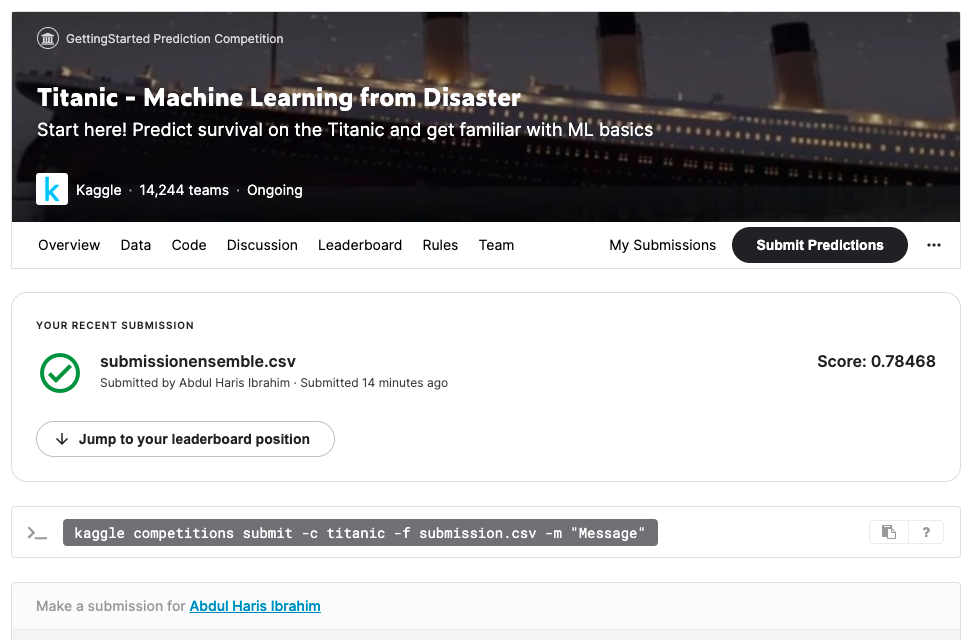

In [62]:
from IPython.display import Image
Image(filename='accuracy.png')